# Simple PKRO model

In this example, we'll use PySB with the `pysb-pkpd` add-on to build the simple semi-mechanistic pharmacokinetic receptor-occupancy (PKRO) model pictured below: 

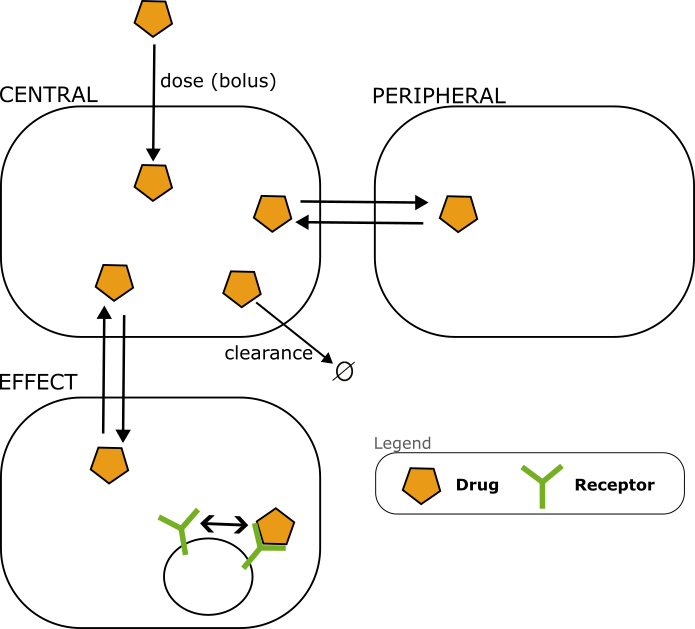

In [1]:
from IPython.display import Image, display
display(Image(filename='1_simple-PKRO_schematic.png'))

This model is a three-compartment model with a central compartment (circulation), effect compartment (tissue/organ where the drugs target is expressed), and peripheral compartment (all other tissue/organs). 

The drug can distribute reversibly between each compartment and undergoes linear clearance from the central compartment. 

The drug targets a receptor expressed in the effect compartment through reversible binding to the receptor (or receptor occupancy). 


## Building the model

To build the model we'll use a combination of standard PySB model components:

In [2]:
from pysb import Model, Monomer, Parameter, Observable, Initial, Expression, ANY, WILD

As well as one of the standard PySB macros:

In [3]:
from pysb.macros import bind

And macros from the `pysb-pkpd` add-on:

In [4]:
import pysb.pkpd as pkpd

Now, we can construct the model. We won't worry too much about the accuracy of the model parameters since this is just an example case: 

In [5]:
## Build the model.
# Initialize the PySB model.
Model()
# Define the Drug with one binding site.
Monomer("Drug", ['b'])
# Alias the free drug.
free_drug = Drug(b=None)
# Define the target receptor with one binding site.
Monomer('Receptor', ['b'])
# Three-compartment model:
#  c1 - CENTRAL (circulation)
#  c2 - PERIPHERAL (other organs/tissue)
#  c3 - EFFECT (effect site/organ/tissue)
# Each compartment is assumed to be 1 L.
pkpd.three_compartments(c3_name='EFFECT')
# Add a single Bolus dose of the Drug.
pkpd.dose_bolus(free_drug, CENTRAL, 200.) # mg
# Initialize the receptor in the EFFECT compartment.
Parameter('R_0', 0.1) # mg/L
Initial(Receptor(b=None)**EFFECT, R_0) 
# Distribution/re-distribution:
#   CENTRAL <-> PERIPHERAL
pkpd.distribute(free_drug, CENTRAL, PERIPHERAL, [0.01, 0.05]) # mg/minute
#   CENTRAL <-> EFFECT
pkpd.distribute(free_drug, CENTRAL, EFFECT, [0.025, 0.011])
# Clearance of the drug from the CENTRAL compartment.
pkpd.clearance(free_drug, CENTRAL, 1e-1) # L/minute
# Binding of the Drug to the Receptor - i.e., recptor occupancy.
bind(free_drug**EFFECT, 'b', Receptor(b=None)**EFFECT, 'b', [3e-4, 1e-4])
# Define the model observables:
#    Receptor-Drug complex and occupancy.
Observable('Rbound', Receptor(b=ANY)**EFFECT)
Observable('Rtotal', Receptor(b=WILD)**EFFECT)
Expression('RO', Rbound / Rtotal)
#    Free drug in each compartment.
Observable('D_C', free_drug**CENTRAL)
Observable('D_P', free_drug**PERIPHERAL)
Observable('D_E', free_drug**EFFECT)

Observable('D_E', Drug(b=None) ** EFFECT)

In [6]:
model

<Model '_interactive_' (monomers: 2, rules: 4, parameters: 12, expressions: 3, compartments: 3, energypatterns: 0) at 0x22456e62d50>

### Simulating the model

In [7]:
from pysb.simulator import ScipyOdeSimulator
import numpy as np
import matplotlib.pyplot as plt

In [8]:
tspan = np.arange(0, 60*48) # minutes

In [9]:
print("Simulating...")
yfull = ScipyOdeSimulator(model).run(tspan=tspan).all

Simulating...


In [10]:
tspan_hr = tspan / 60

#### PK data

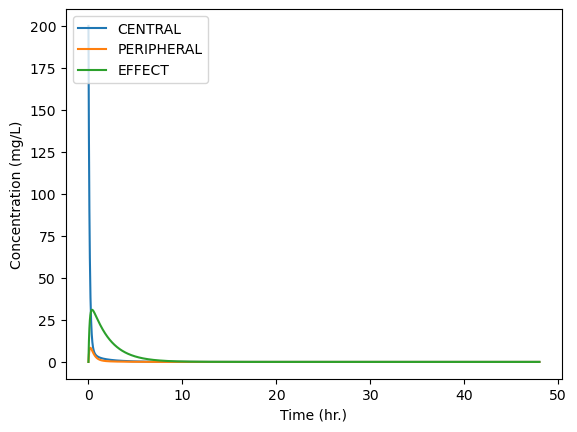

In [11]:
plt.plot(tspan_hr, yfull['D_C'], label='CENTRAL')
plt.plot(tspan_hr , yfull['D_P'], label='PERIPHERAL')
plt.plot(tspan_hr , yfull['D_E'], label='EFFECT')
plt.ylabel("Concentration (mg/L)")
plt.xlabel("Time (hr.)")
plt.legend(loc='upper left')
plt.show()

#### Receptor occupancy (RO)

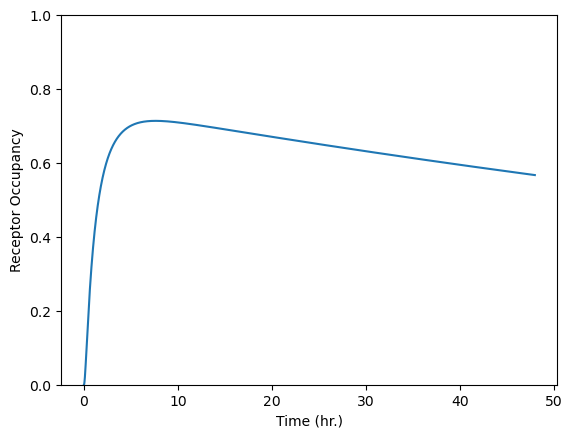

In [12]:
plt.plot(tspan_hr, yfull['RO'], label='Occupancy')
plt.ylabel("Receptor Occupancy")
plt.xlabel("Time (hr.)")
plt.ylim((0,1))
#plt.legend(loc='upper left')
plt.show()